In [1]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# [1] 빈칸을 작성하시오.
# Connect Directory
%cd /content/drive/MyDrive/OUTTA_AI_BOOTCAMP/Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/OUTTA_AI_BOOTCAMP/Project


In [2]:
!pip install diffusers
!pip install -q -U google-generativeai
!pip install accelerate

In [3]:
import os
import sys
import random
from io import BytesIO

import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.models.vgg as vgg

from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download

from read_dataset import read_dataset
from model import segmentation_model
from train import train
from segmentation import segementation
from diffusion import *
from llm import *
from preprop import *

# Jupyter Notebook 내에서 matplotlib 출력 설정
%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 32   # 절대 바꾸지 마세요.

n_class = 50
model = segmentation_model(n_class).to(device)

# 하이퍼파라이터
epoch = 5
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **1. Train**

In [5]:
file_path = 'dataset/G2_train.h5'
data_len = 10000
img_list, gt_list = read_dataset(file_path, data_len)

In [6]:
train(img_list, gt_list, model, epoch, learning_rate, optimizer, criterion, data_len, device)

Iteration: 100, Loss: 2.322242034543859
Iteration: 200, Loss: 1.5402680693277673
Iteration: 300, Loss: 1.2227321468120398
Iteration: 400, Loss: 1.0341601624453156
Iteration: 500, Loss: 0.9198648059617973
Iteration: 600, Loss: 0.840283956310515
Iteration: 700, Loss: 0.7790232670842836
Iteration: 800, Loss: 0.727214429969347
Iteration: 900, Loss: 0.6835507673276516
Iteration: 1000, Loss: 0.6458114151071597
Iteration: 1100, Loss: 0.6146494038842896
Iteration: 1200, Loss: 0.5869108132838111
Iteration: 1300, Loss: 0.5637354118252699
Iteration: 1400, Loss: 0.5412866856682139
Iteration: 1500, Loss: 0.5226224719644149
Iteration: 1600, Loss: 0.5047201877046867
Iteration: 1700, Loss: 0.4891403950159512
Iteration: 1800, Loss: 0.4753504933076789
Iteration: 1900, Loss: 0.4621933930245341
Iteration: 2000, Loss: 0.4502827924402102
Iteration: 2100, Loss: 0.43929866793920513
Iteration: 2200, Loss: 0.4299479047211394
Iteration: 2300, Loss: 0.4203330655847358
Iteration: 2400, Loss: 0.41112853242538216
It

# **2. Inference**

## **(1) Set the Model into Eval Mode**

In [7]:
model = segmentation_model(n_class)

# 가중치를 CPU로 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/OUTTA_AI_BOOTCAMP/Project/model_state_dict0.pth', map_location=torch.device('cpu')))

# 모델을 평가 모드로 설정
model.eval()

<ipython-input-7-76b9d7aa2278>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/OUTTA_AI_BOOTCAMP/Project/model_stat

segmentation_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

## **(2) Load Image**

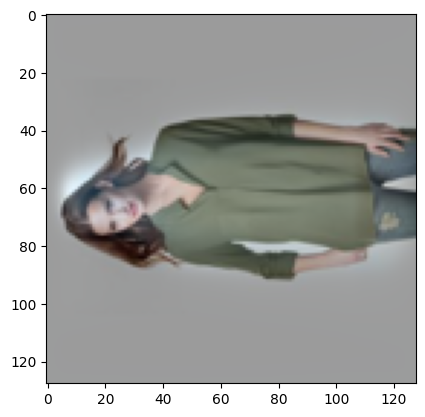

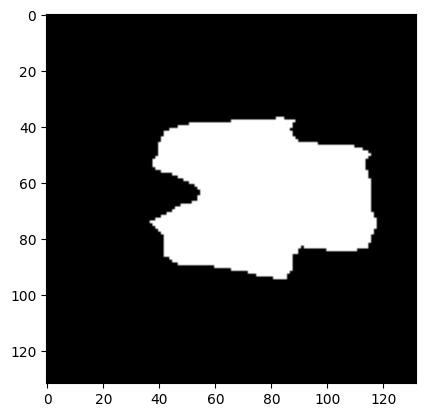

In [8]:
image = np.load('./test_image3.npy')
plt.imshow(image)
plt.show()

# 결과 시각화
vis_output_model = segementation(image, model)
plt.imshow(vis_output_model)
plt.show()

## **(3) Inference**

### **1) LLM**

In [9]:
# [2] 빈칸을 작성하시오.
# 적절한 프롬프트 튜닝을 통해서, 좋은 성능을 내보세요.
# [Example]
# prompt = "A Red short skirt, high quality, detailed, cute, with a lot of details, ."
# negative_prompt = "ugly"
prompt = "I want a black leather jacket with a slim fit, made of soft, suitable for casual wear. The top should have a clean and modern design, with no patterns or logos."
negative_prompt = "blurred, low-resolution, distorted, unrealistic"

text = LLM(prompt)
text.text

'{"top": ["black", "leather jacket", "slim fit", "casual", "clean and modern design", "no patterns or logos"]}'

### **2) Segmentation & Inpainting**
- SAM for Segmentation

- Stable Diffusion for inpainting

In [10]:
# [3] 빈칸을 작성하시오.
# 사전학습된 StableDiffusionInpaintPipeline 불러오고, GPU로 로드

sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

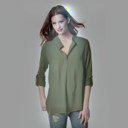

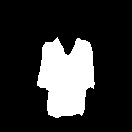

In [11]:
# [4] 빈칸을 작성하시오.
# 이미지와 모델을 받아 Diffusion 모델에 적합한 형태로 전처리하는 함수 호출
image_source_pil, image_mask_pil = preprop_for_diffusion(image, vis_output_model)

In [12]:
# [5] 빈칸을 작성하시오.
# 이미지 생성 함수 호출: 주어진 이미지와 마스크를 기반으로 새로운 이미지를 생성
generated_image = generate_image(image_source_pil, image_mask_pil, prompt, negative_prompt, sd_pipe, seed, device)

# [6] 빈칸을 작성하시오.
# 생성된 이미지의 크기 조정
resized_image = generated_image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

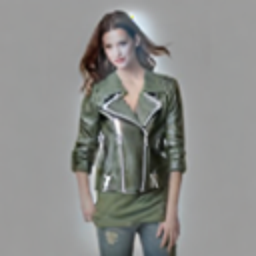

In [13]:
resized_image